In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime


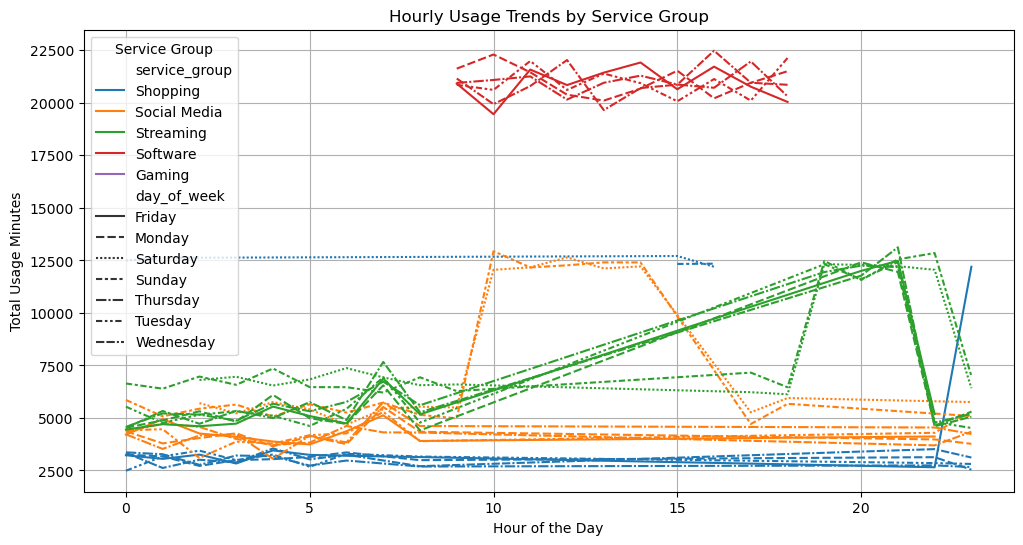

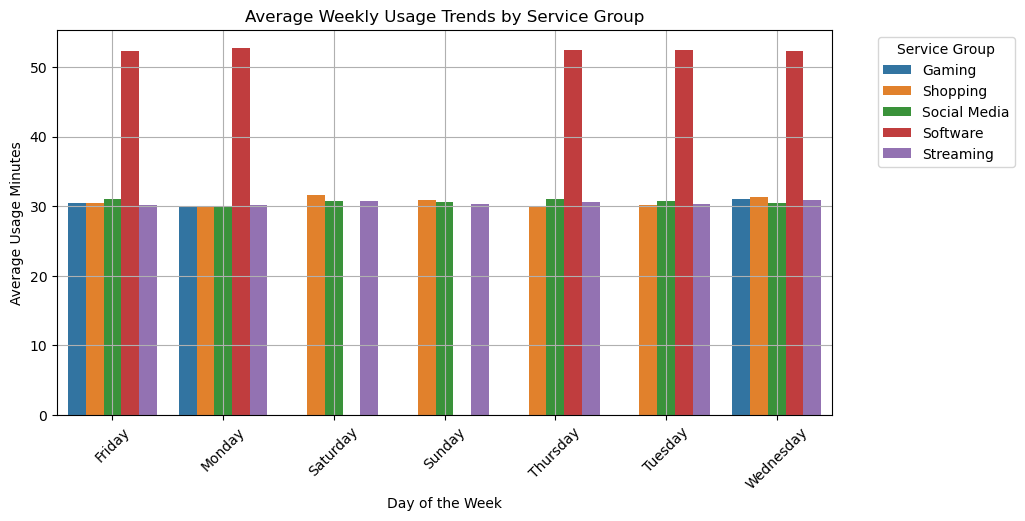

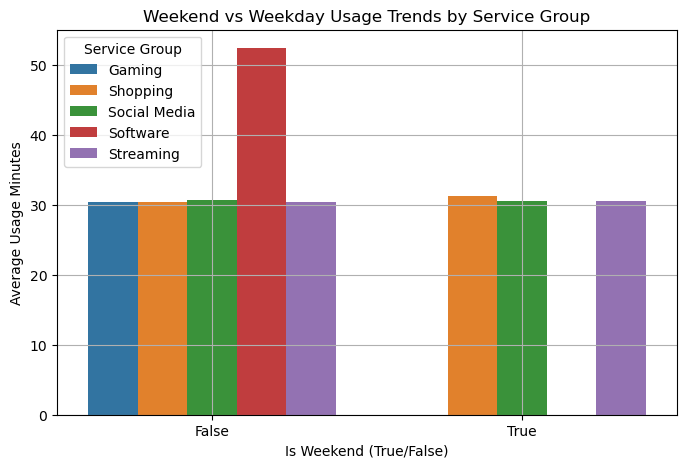

/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


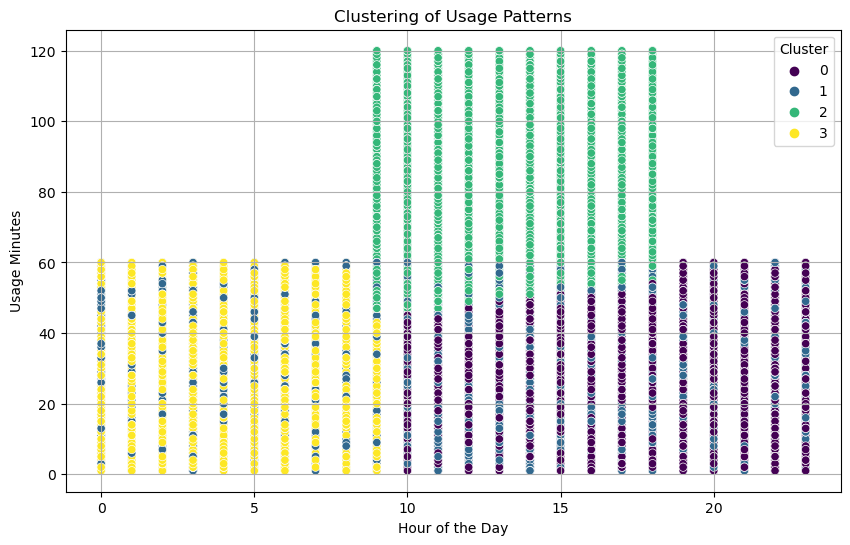

              hour  usage_minutes  is_weekend  service_group_Shopping  \
cluster                                                                 
0        17.675481      29.481485         0.0                0.065364   
1        11.499398      30.682491         1.0                0.124836   
2        13.250658      79.052427         0.0                0.000000   
3         4.250409      30.356958         0.0                0.212729   

         service_group_Social Media  service_group_Software  \
cluster                                                       
0                          0.063727                0.488543   
1                          0.432086                0.000000   
2                          0.000000                1.000000   
3                          0.326086                0.050082   

         service_group_Streaming  
cluster                           
0                       0.320990  
1                       0.443078  
2                       0.000000  
3      

In [12]:

# Load the dataset
dataset_path = 'netflix_single_user_balanced_pattern_v5.csv'  # Replace with your actual file path
data = pd.read_csv(dataset_path)

# Convert timestamp to datetime format and extract temporal features
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.day_name()
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday'])

# ====================================
# 1. Exploratory Data Analysis (EDA)
# ====================================

# Aggregating usage patterns
daily_usage = data.groupby(['day_of_week', 'hour', 'service_group']).agg(
    usage_minutes=('usage_minutes', 'sum')).reset_index()

# Average usage minutes per day of the week
weekly_usage = data.groupby(['day_of_week', 'service_group'])['usage_minutes'].mean().reset_index()

# Plotting hourly usage trends
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_usage, 
    x='hour', 
    y='usage_minutes', 
    hue='service_group', 
    style='day_of_week'
)
plt.title("Hourly Usage Trends by Service Group")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Usage Minutes")
plt.legend(title="Service Group")
plt.grid()
plt.show()

# Plotting weekly usage trends
plt.figure(figsize=(10, 5))
sns.barplot(
    data=weekly_usage, 
    x='day_of_week', 
    y='usage_minutes', 
    hue='service_group'
)
plt.title("Average Weekly Usage Trends by Service Group")
plt.xlabel("Day of the Week")
plt.ylabel("Average Usage Minutes")
plt.legend(title="Service Group", bbox_to_anchor=(1.05, 1))
plt.grid()
plt.xticks(rotation=45)
plt.show()

# Weekend vs Weekday usage analysis
weekend_usage = data.groupby(['is_weekend', 'service_group'])['usage_minutes'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=weekend_usage, 
    x='is_weekend', 
    y='usage_minutes', 
    hue='service_group'
)
plt.title("Weekend vs Weekday Usage Trends by Service Group")
plt.xlabel("Is Weekend (True/False)")
plt.ylabel("Average Usage Minutes")
plt.legend(title="Service Group")
plt.grid()
plt.show()

# ====================================
# 2. Clustering Analysis
# ====================================

# Feature selection for clustering
clustering_data = data[['hour', 'usage_minutes', 'is_weekend', 'service_group']].copy()

# One-hot encode the 'service_group' column
clustering_data = pd.get_dummies(clustering_data, columns=['service_group'], drop_first=True)

# Standardize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_data[['hour', 'usage_minutes', 'is_weekend']])

# Append the one-hot encoded columns to the scaled features
encoded_features = np.hstack((scaled_features, clustering_data.iloc[:, 3:].values))

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust clusters based on behavior complexity
clustering_data['cluster'] = kmeans.fit_predict(encoded_features)

# Visualizing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=clustering_data['hour'], 
    y=clustering_data['usage_minutes'], 
    hue=clustering_data['cluster'], 
    palette='viridis'
)
plt.title("Clustering of Usage Patterns")
plt.xlabel("Hour of the Day")
plt.ylabel("Usage Minutes")
plt.legend(title="Cluster")
plt.grid()
plt.show()

# Analyzing cluster characteristics
cluster_summary = clustering_data.groupby('cluster').mean()
print(cluster_summary)

# ====================================
# 3. Preparing for Forecasting
# ====================================

# Aggregate data for time series forecasting
forecast_data = data.groupby(['timestamp', 'service_group'])['usage_minutes'].sum().unstack(fill_value=0).reset_index()
forecast_data.set_index('timestamp', inplace=True)

# Save prepared data for forecasting
forecast_data.to_csv('forecast_ready_data.csv')  # Export for external time-series forecasting

print("Forecast data prepared and saved.")


In [16]:
!pip install ace_tools

  Obtaining dependency information for ace_tools from https://files.pythonhosted.org/packages/27/c4/402d3ae2ecbfe72fbdcb2769f55580f1c54a3ca110c44e1efc034516a499/ace_tools-0.0-py3-none-any.whl.metadata


Missing Values:
 Gaming          0
Shopping        0
Social Media    0
Software        0
Streaming       0
dtype: int64


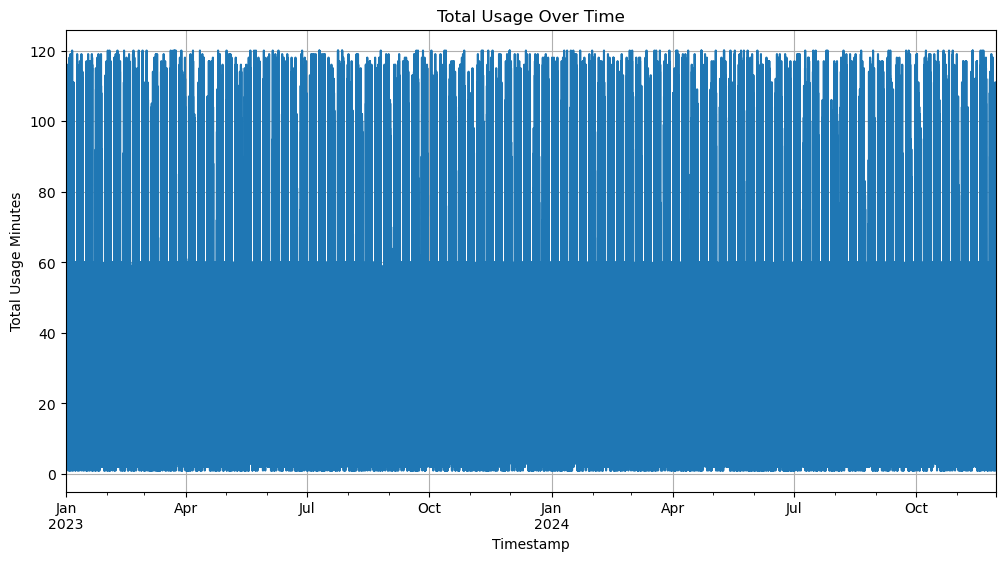

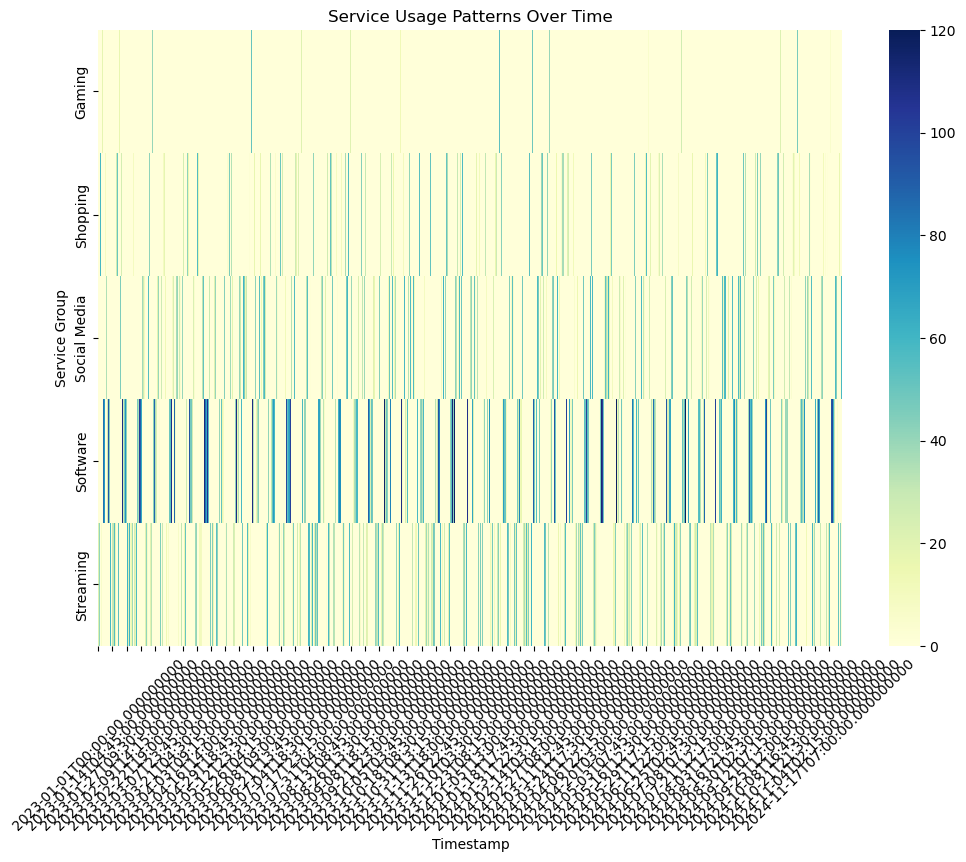

/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


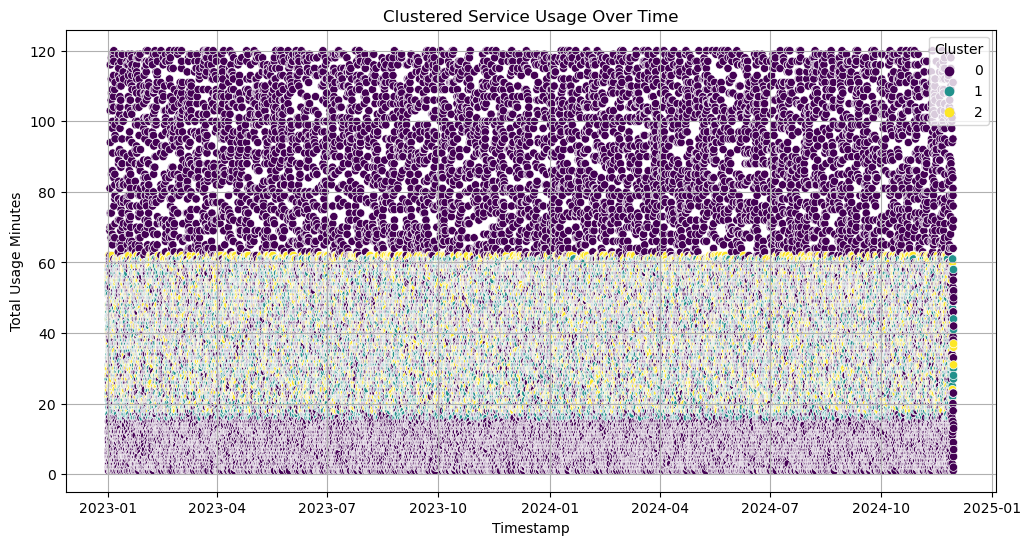

Cluster Summary of Forecast Data:
           Gaming  Shopping  Social Media   Software  Streaming
cluster                                                        
0        0.962099  6.208048      0.815650  27.590321   1.044897
1        0.000000  0.000000      0.000000   0.000000  37.478266
2        0.000000  0.000000     38.017327   0.000000   0.000000
Time-series forecast data prepared and saved as 'time_series_forecast_data.csv'.


In [18]:
# Load the forecast-ready dataset
forecast_ready_data_path = 'forecast_ready_data.csv'  # Replace with the correct path
forecast_data = pd.read_csv(forecast_ready_data_path, parse_dates=['timestamp'])
forecast_data.set_index('timestamp', inplace=True)

# ====================================
# 1. EDA for Forecast Data
# ====================================

# Check for missing values
print("Missing Values:\n", forecast_data.isnull().sum())

# Plot aggregated usage trends
plt.figure(figsize=(12, 6))
forecast_data.sum(axis=1).plot()
plt.title("Total Usage Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.grid()
plt.show()

# Heatmap of service usage patterns
plt.figure(figsize=(12, 8))
sns.heatmap(forecast_data.T, cmap='YlGnBu', cbar=True)
plt.title("Service Usage Patterns Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Service Group")
plt.xticks(rotation=45)
plt.show()

# ====================================
# 2. Clustering on Forecast Data
# ====================================

# Scaling the data for clustering
scaler = StandardScaler()
scaled_forecast_data = scaler.fit_transform(forecast_data)

# Apply KMeans clustering
kmeans_forecast = KMeans(n_clusters=3, random_state=42)  # Adjust clusters based on data
forecast_data['cluster'] = kmeans_forecast.fit_predict(scaled_forecast_data)

# Visualize clusters over time
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=forecast_data.index, 
    y=forecast_data.sum(axis=1), 
    hue=forecast_data['cluster'], 
    palette='viridis'
)
plt.title("Clustered Service Usage Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.legend(title="Cluster")
plt.grid()
plt.show()

# Analyze cluster characteristics
cluster_summary = forecast_data.groupby('cluster').mean()
print("Cluster Summary of Forecast Data:")
print(cluster_summary)

# ====================================
# 3. Forecast Preparation
# ====================================

# Extract data for time-series forecasting
forecast_ready = forecast_data.drop(columns=['cluster'])

# Save time-series data for forecasting
forecast_ready.to_csv('time_series_forecast_data.csv')

print("Time-series forecast data prepared and saved as 'time_series_forecast_data.csv'.")


/Users/nethrashri/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                53684
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -248181.495
Date:                Tue, 26 Nov 2024   AIC                         496374.989
Time:                        01:32:37   BIC                         496428.335
Sample:                    01-01-2023   HQIC                        496391.645
                         - 07-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8113      0.004   -219.692      0.000      -0.819      -0.804
ar.L2         -0.6358      0.005   -136.689      0.000      -0.645      -0.627
ar.L3         -0.4658      0.005    -94.324      0.0

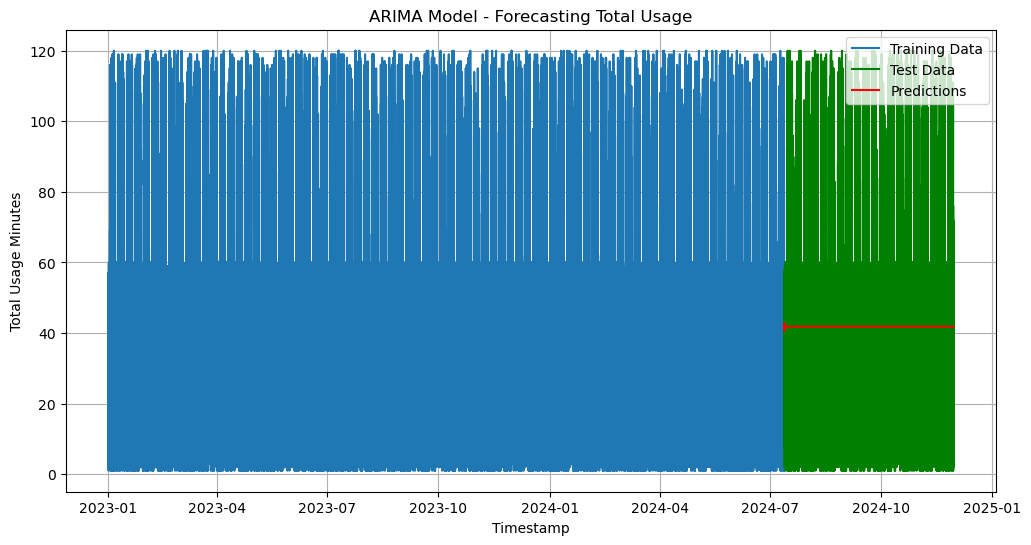

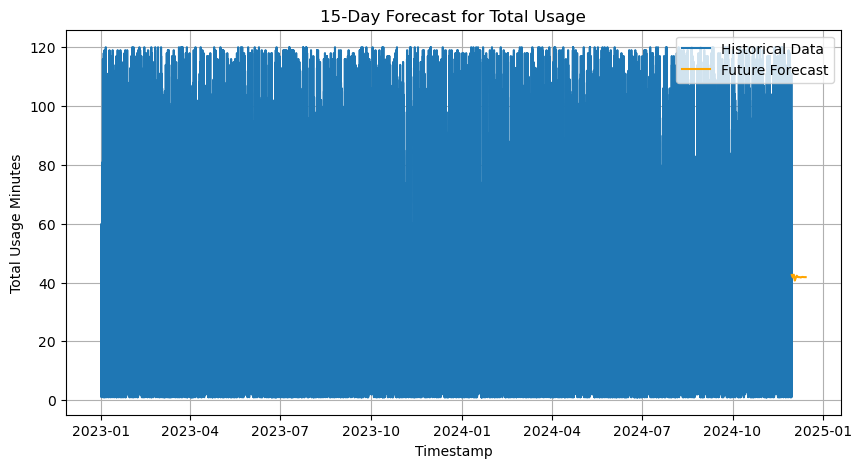

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the time-series data
forecast_ready_data_path = 'time_series_forecast_data.csv'  # Replace with actual path
forecast_data = pd.read_csv(forecast_ready_data_path, parse_dates=['timestamp'], index_col='timestamp')

# Aggregate total usage (univariate forecast)
total_usage = forecast_data.sum(axis=1)

# ====================================
# 1. Split the Data
# ====================================

# Define training (80%) and testing (20%) sets
train_size = int(len(total_usage) * 0.8)
train_data, test_data = total_usage[:train_size], total_usage[train_size:]

# ====================================
# 2. Fit ARIMA Model
# ====================================

# Configure ARIMA parameters (p, d, q)
arima_model = ARIMA(train_data, order=(5, 1, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_result = arima_model.fit()

# Summary of the model
print(arima_result.summary())

# ====================================
# 3. Forecast and Evaluate
# ====================================

# Make predictions
predictions = arima_result.forecast(steps=len(test_data))
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# ====================================
# 4. Visualize Predictions
# ====================================

plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Test Data", color='green')
plt.plot(test_data.index, predictions, label="Predictions", color='red')
plt.title("ARIMA Model - Forecasting Total Usage")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()

# ====================================
# 5. Forecast for Future Periods
# ====================================

# Forecast for the next 15 days (or appropriate period)
future_forecast = arima_result.forecast(steps=15)

plt.figure(figsize=(10, 5))
plt.plot(total_usage, label="Historical Data")
plt.plot(
    pd.date_range(total_usage.index[-1], periods=15, freq='D'), 
    future_forecast, 
    label="Future Forecast", 
    color='orange'
)
plt.title("15-Day Forecast for Total Usage")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()


/Users/nethrashri/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                53684
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -246367.159
Date:                Tue, 26 Nov 2024   AIC                         492744.318
Time:                        01:37:45   BIC                         492788.773
Sample:                    01-01-2023   HQIC                        492758.198
                         - 07-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8406     42.133     -0.020      0.984     -83.419      81.738
ar.L2          0.0046      0.228      0.020      0.984      -0.442       0.451
ma.L1         -0.0487     42.133     -0.001      0.9

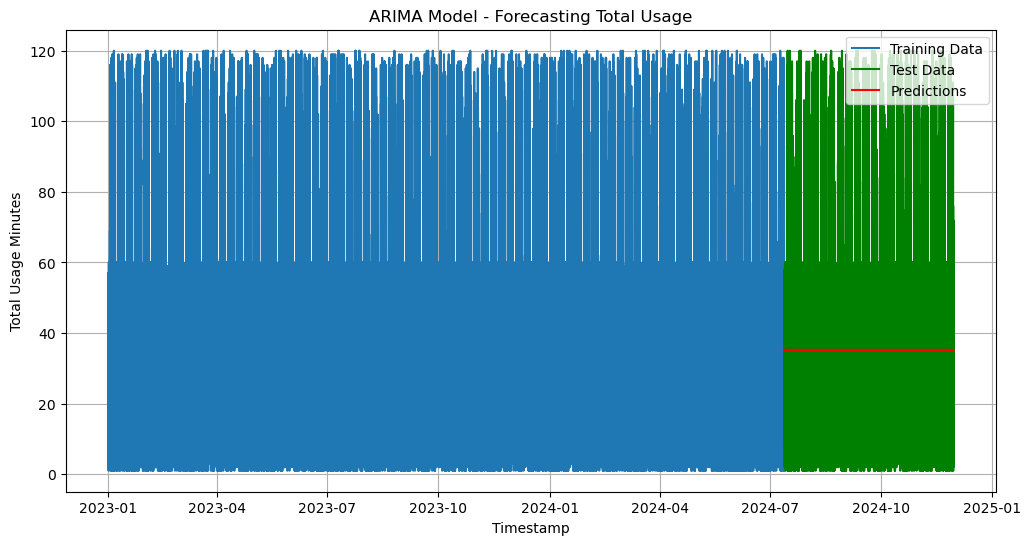

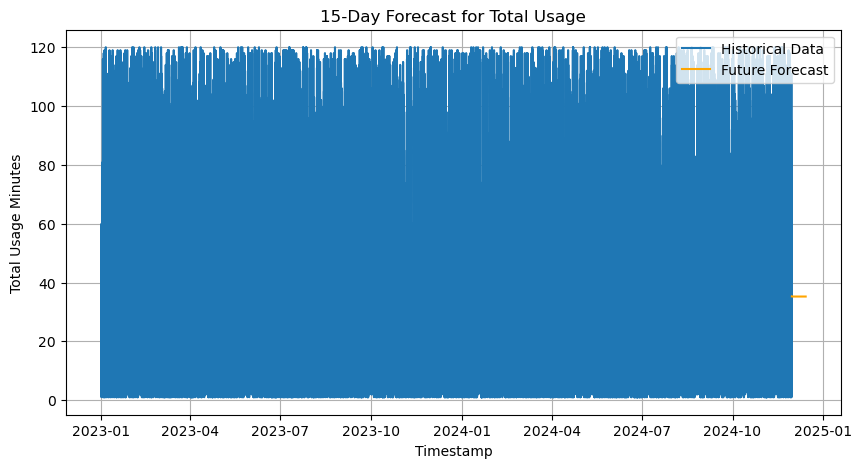

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# ====================================
# 1. Configure ARIMA Parameters (p, d, q)
# ====================================
# Use PACF to determine `p`, differencing to determine `d`, and ACF to determine `q`
p = 2  # Based on PACF spikes
d = 1  # Differencing for stationarity
q = 2  # Based on ACF spikes

# ====================================
# 2. Split the Data
# ====================================
# Define training (80%) and testing (20%) sets
train_size = int(len(total_usage) * 0.8)
train_data, test_data = total_usage[:train_size], total_usage[train_size:]

# ====================================
# 3. Fit ARIMA Model
# ====================================
# Fit ARIMA model
arima_model = ARIMA(train_data, order=(p, d, q))
arima_result = arima_model.fit()

# Display model summary
print(arima_result.summary())

# ====================================
# 4. Forecast and Evaluate
# ====================================
# Forecast the test data
predictions = arima_result.forecast(steps=len(test_data))

# Calculate evaluation metrics
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# ====================================
# 5. Visualize Predictions
# ====================================
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Test Data", color='green')
plt.plot(test_data.index, predictions, label="Predictions", color='red')
plt.title("ARIMA Model - Forecasting Total Usage")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()

# ====================================
# 6. Forecast for Future Periods
# ====================================
# Forecast for the next 15 days
future_forecast = arima_result.forecast(steps=15)

# Plot the future forecast
plt.figure(figsize=(10, 5))
plt.plot(total_usage, label="Historical Data")
plt.plot(
    pd.date_range(total_usage.index[-1], periods=15, freq='D'), 
    future_forecast, 
    label="Future Forecast", 
    color='orange'
)
plt.title("15-Day Forecast for Total Usage")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()


2024-11-26 11:36:46.951659: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-26 11:36:46.951691: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-26 11:36:46.951697: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-26 11:36:46.951751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 11:36:46.951797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2024-11-26 11:36:47.968126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1678/1678 [==============================] - 23s 12ms/step - loss: 0.0399 - val_loss: 0.0411
Epoch 2/20
1678/1678 [==============================] - 18s 10ms/step - loss: 0.0395 - val_loss: 0.0393
Epoch 3/20
1678/1678 [==============================] - 18s 10ms/step - loss: 0.0392 - val_loss: 0.0390
Epoch 4/20
1678/1678 [==============================] - 18s 11ms/step - loss: 0.0389 - val_loss: 0.0386
Epoch 5/20
1678/1678 [==============================] - 18s 11ms/step - loss: 0.0388 - val_loss: 0.0383
Epoch 6/20
1678/1678 [==============================] - 18s 11ms/step - loss: 0.0386 - val_loss: 0.0381
Epoch 7/20
1678/1678 [==============================] - 18s 11ms/step - loss: 0.0384 - val_loss: 0.0382
Epoch 8/20
1678/1678 [==============================] - 18s 11ms/step - loss: 0.0383 - val_loss: 0.0381
Epoch 9/20
1678/1678 [==============================] - 18s 11ms/step - loss: 0.0383 - val_loss: 0.0381
Epoch 10/20
1678/1678 [==============================] - 18s 11ms/step - lo

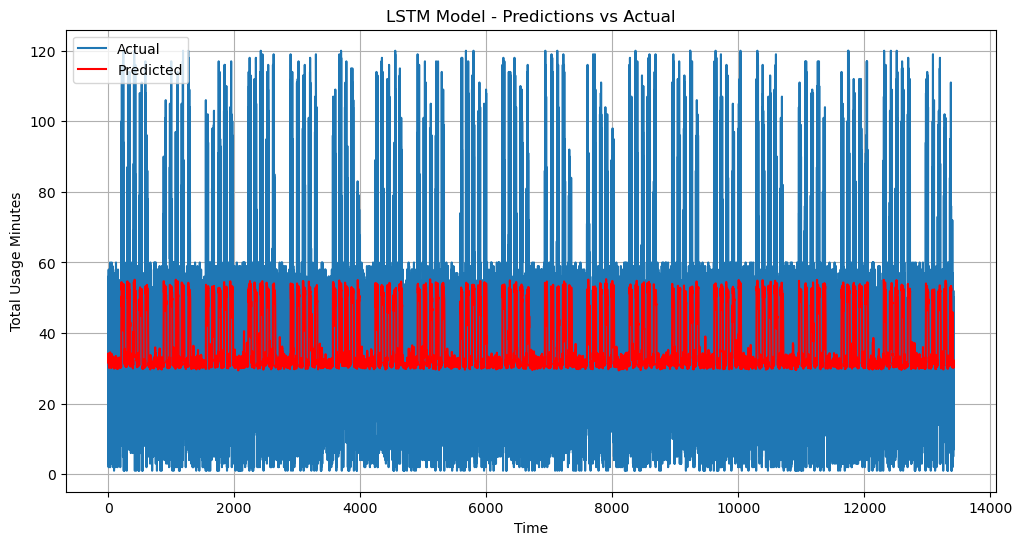

1/1 [==============================] - 0s 10ms/step


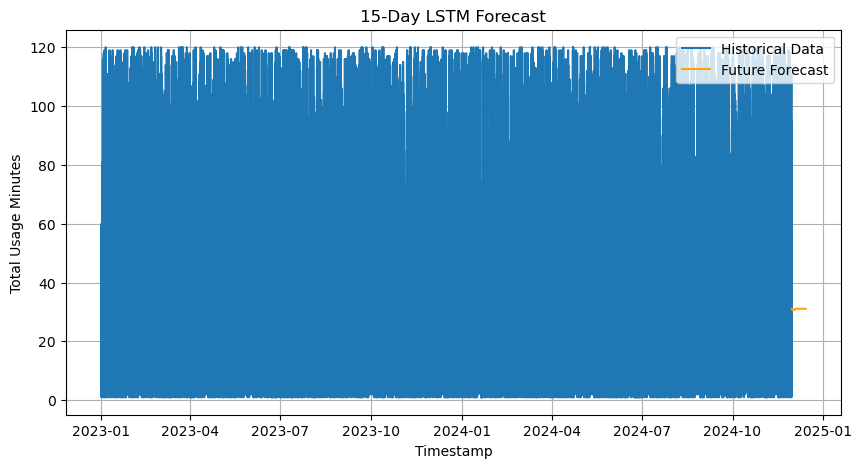

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

# ====================================
# 1. Data Preparation
# ====================================
# Load the time-series data
forecast_ready_data_path = 'time_series_forecast_data.csv'  # Replace with your actual path
forecast_data = pd.read_csv(forecast_ready_data_path, parse_dates=['timestamp'], index_col='timestamp')

# Aggregate total usage (univariate forecast)
total_usage = forecast_data.sum(axis=1)  # Summing across columns for total usage

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(total_usage.values.reshape(-1, 1))

# Convert time series data to sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Sequence length for LSTM
sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ====================================
# 2. Build the LSTM Model
# ====================================
model = Sequential([
    LSTM(50, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.0, input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(50, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.0),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# ====================================
# 3. Train the Model
# ====================================
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# ====================================
# 4. Evaluate and Visualize Predictions
# ====================================
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual")
plt.plot(predictions, label="Predicted", color='red')
plt.title("LSTM Model - Predictions vs Actual")
plt.xlabel("Time")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()

# ====================================
# 5. Forecast for Future Periods
# ====================================
# Forecast for the next 15 periods
forecast_input = scaled_data[-sequence_length:]  # Use the last sequence from the dataset
forecast_output = []

for _ in range(15):  # Generate 15 forecasts
    forecast_prediction = model.predict(forecast_input.reshape(1, sequence_length, 1))
    forecast_output.append(forecast_prediction[0, 0])
    forecast_input = np.append(forecast_input[1:], forecast_prediction, axis=0)

# Inverse transform forecasts
forecast_output = scaler.inverse_transform(np.array(forecast_output).reshape(-1, 1))

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(total_usage.index, total_usage, label="Historical Data")
plt.plot(
    pd.date_range(total_usage.index[-1], periods=15, freq='D'),
    forecast_output,
    label="Future Forecast",
    color='orange'
)
plt.title("15-Day LSTM Forecast")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()


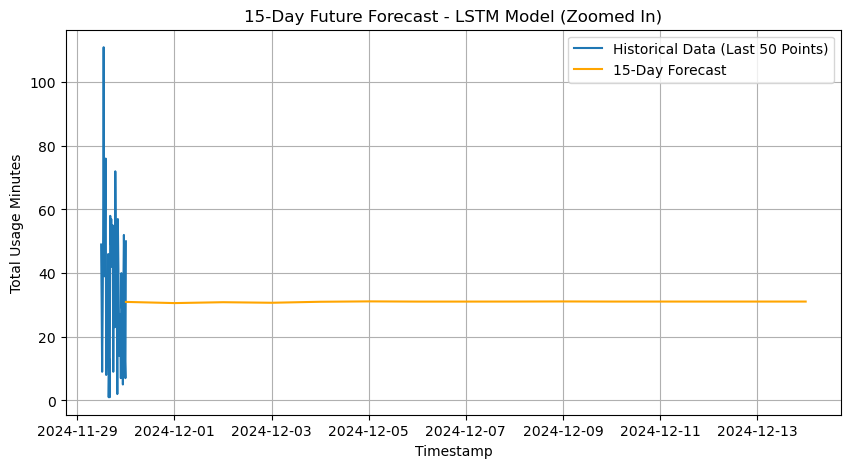

In [5]:
# Plot the last 50 points of historical data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(total_usage[-50:], label="Historical Data (Last 50 Points)")
plt.plot(
    pd.date_range(total_usage.index[-1], periods=15, freq="D"),
    forecast_output,
    label="15-Day Forecast",
    color="orange"
)
plt.title("15-Day Future Forecast - LSTM Model (Zoomed In)")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

# ====================================
# 1. Data Preparation
# ====================================
# Load the time-series data
forecast_ready_data_path = 'time_series_forecast_data.csv'  # Replace with your actual path
forecast_data = pd.read_csv(forecast_ready_data_path, parse_dates=['timestamp'], index_col='timestamp')

# Aggregate total usage (univariate forecast)
total_usage = forecast_data.sum(axis=1)

# Add day-of-week as a feature
forecast_data['day_of_week'] = forecast_data.index.dayofweek
day_of_week_encoded = pd.get_dummies(forecast_data['day_of_week'], prefix='day')
forecast_data = pd.concat([forecast_data, day_of_week_encoded], axis=1)

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(total_usage.values.reshape(-1, 1))

# Convert time series data to sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Sequence length for LSTM
sequence_length = 20  # Increased sequence length for better context
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ====================================
# 2. Build and Train the LSTM Model
# ====================================
model = Sequential([
    LSTM(64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2, 
         input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model for more epochs
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# ====================================
# 3. Evaluate and Visualize Predictions
# ====================================
# Make predictions after training
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Values")
plt.plot(predictions, label="Predicted Values", color="red")
plt.title("Actual vs Predicted Values - LSTM Model with Day-of-Week Feature")
plt.xlabel("Time")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()

# ====================================
# 4. Future Forecast Analysis (15-Day Forecast)
# ====================================
forecast_input = scaled_data[-sequence_length:]
forecast_output = []

# Generate 15-day forecasts
for _ in range(15):
    forecast_prediction = model.predict(forecast_input.reshape(1, sequence_length, 1))
    forecast_output.append(forecast_prediction[0, 0])
    forecast_input = np.append(forecast_input[1:], forecast_prediction, axis=0)

# Inverse transform the forecasted values
forecast_output = scaler.inverse_transform(np.array(forecast_output).reshape(-1, 1))

# Plot the historical data and 15-day forecast
plt.figure(figsize=(10, 5))
plt.plot(total_usage[-50:], label="Historical Data (Last 50 Points)")
plt.plot(
    pd.date_range(total_usage.index[-1], periods=15, freq="D"),
    forecast_output,
    label="15-Day Forecast",
    color="orange"
)
plt.title("15-Day Future Forecast - LSTM Model with Day-of-Week Feature")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()


Epoch 1/100
1559/3355 [============>.................] - ETA: 38:39 - loss: 0.0413

In [ ]:
## Increasing neurons and adding more hidden layers


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

# ====================================
# 1. Data Preparation
# ====================================
# Load the time-series data
forecast_ready_data_path = 'time_series_forecast_data.csv'  # Replace with your actual path
forecast_data = pd.read_csv(forecast_ready_data_path, parse_dates=['timestamp'], index_col='timestamp')

# Aggregate total usage (univariate forecast)
total_usage = forecast_data.sum(axis=1)

# Add day-of-week as a feature
forecast_data['day_of_week'] = forecast_data.index.dayofweek
day_of_week_encoded = pd.get_dummies(forecast_data['day_of_week'], prefix='day')
forecast_data = pd.concat([forecast_data, day_of_week_encoded], axis=1)

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(total_usage.values.reshape(-1, 1))

# Convert time series data to sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Sequence length for LSTM
sequence_length = 20  # Increased sequence length for better context
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ====================================
# 2. Build and Train the LSTM Model with 4 Layers
# ====================================
model = Sequential([
    LSTM(50, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2, 
         input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(50, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True),
    LSTM(50, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True),
    LSTM(50, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model for more epochs
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# ====================================
# 3. Evaluate and Visualize Predictions
# ====================================
# Make predictions after training
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Values")
plt.plot(predictions, label="Predicted Values", color="red")
plt.title("Actual vs Predicted Values - LSTM Model with 4 Layers")
plt.xlabel("Time")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()

# ====================================
# 4. Future Forecast Analysis (15-Day Forecast)
# ====================================
forecast_input = scaled_data[-sequence_length:]
forecast_output = []

# Generate 15-day forecasts
for _ in range(15):
    forecast_prediction = model.predict(forecast_input.reshape(1, sequence_length, 1))
    forecast_output.append(forecast_prediction[0, 0])
    forecast_input = np.append(forecast_input[1:], forecast_prediction, axis=0)

# Inverse transform the forecasted values
forecast_output = scaler.inverse_transform(np.array(forecast_output).reshape(-1, 1))

# Plot the historical data and 15-day forecast
plt.figure(figsize=(10, 5))
plt.plot(total_usage[-50:], label="Historical Data (Last 50 Points)")
plt.plot(
    pd.date_range(total_usage.index[-1], periods=15, freq="D"),
    forecast_output,
    label="15-Day Forecast",
    color="orange"
)
plt.title("15-Day Future Forecast - LSTM Model with 4 Layers")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Increated to 9 layers 


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

# ====================================
# 1. Data Preparation
# ====================================
# Load the time-series data
forecast_ready_data_path = 'time_series_forecast_data.csv'  # Replace with your actual path
forecast_data = pd.read_csv(forecast_ready_data_path, parse_dates=['timestamp'], index_col='timestamp')

# Aggregate total usage (univariate forecast)
total_usage = forecast_data.sum(axis=1)

# Add day-of-week as a feature
forecast_data['day_of_week'] = forecast_data.index.dayofweek
day_of_week_encoded = pd.get_dummies(forecast_data['day_of_week'], prefix='day')
forecast_data = pd.concat([forecast_data, day_of_week_encoded], axis=1)

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(total_usage.values.reshape(-1, 1))

# Convert time series data to sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Sequence length for LSTM
sequence_length = 20  # Increased sequence length for better context
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ====================================
# 2. Build and Train the LSTM Model with 9 Layers
# ====================================
model = Sequential([
    LSTM(50, activation='relu', recurrent_dropout=0.2, input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(50, activation='relu', recurrent_dropout=0.2, return_sequences=True),
    LSTM(50, activation='relu', recurrent_dropout=0.2, return_sequences=True),
    LSTM(50, activation='relu', recurrent_dropout=0.2, return_sequences=True),
    LSTM(50, activation='relu', recurrent_dropout=0.2, return_sequences=True),
    LSTM(50, activation='relu', recurrent_dropout=0.2, return_sequences=True),
    LSTM(50, activation='relu', recurrent_dropout=0.2, return_sequences=True),
    LSTM(50, activation='relu', recurrent_dropout=0.2, return_sequences=True),
    LSTM(50, activation='sigmoid', recurrent_dropout=0.2)
])

model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model for more epochs
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# ====================================
# 3. Evaluate and Visualize Predictions
# ====================================
# Make predictions after training
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Values")
plt.plot(predictions, label="Predicted Values", color="red")
plt.title("Actual vs Predicted Values - LSTM Model with 9 Layers")
plt.xlabel("Time")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()

# ====================================
# 4. Future Forecast Analysis (15-Day Forecast)
# ====================================
forecast_input = scaled_data[-sequence_length:]
forecast_output = []

# Generate 15-day forecasts
for _ in range(15):
    forecast_prediction = model.predict(forecast_input.reshape(1, sequence_length, 1))
    forecast_output.append(forecast_prediction[0, 0])
    forecast_input = np.append(forecast_input[1:], forecast_prediction, axis=0)

# Inverse transform the forecasted values
forecast_output = scaler.inverse_transform(np.array(forecast_output).reshape(-1, 1))

# Plot the historical data and 15-day forecast
plt.figure(figsize=(10, 5))
plt.plot(total_usage[-50:], label="Historical Data (Last 50 Points)")
plt.plot(
    pd.date_range(total_usage.index[-1], periods=15, freq="D"),
    forecast_output,
    label="15-Day Forecast",
    color="orange"
)
plt.title("15-Day Future Forecast - LSTM Model with 9 Layers")
plt.xlabel("Timestamp")
plt.ylabel("Total Usage Minutes")
plt.legend()
plt.grid()
plt.show()
